# Predicting Remaining Useful Life for Turbofan Engines

In [128]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
import keras
#
%matplotlib inline
np.random.seed(1234)
PYTHONHASHSEED = 0



## Load Data: FD001*

In [129]:
train_df = pd.read_csv('CMAPSSData/train_FD001.txt', sep=' ', header=None)
test_df = pd.read_csv('CMAPSSData/test_FD001.txt', sep=' ', header=None)
truth_df = pd.read_csv('CMAPSSData/RUL_FD001.txt', sep=' ', header=None)


In [130]:
print(train_df.shape, test_df.shape, truth_df.shape)

(20631, 28) (13096, 28) (100, 2)


In [131]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


In [132]:
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,NaN,NaN
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,NaN,NaN
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,NaN,NaN
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,NaN,NaN
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,NaN,NaN


In [133]:
truth_df.head()

,0,1
0,112,NaN
1,98,NaN
2,69,NaN
3,82,NaN
4,91,NaN


Few columns are having Nan values throughout in all the dataframes, we can simply drop those.

We also do not have the column names, hence we can give the names to the columns based on the column data description provided along with the dataset.

In [134]:
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

In [135]:
train_df = train_df.sort_values(['id','cycle'])
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


For the data set FD001, there is only one condition and single fault mode. Hence, the model that we are going to implement must also answer a single question with a binary answer:

Will the engine fail within a fixed number of cycles?
More specifically, will the engine fail within next 30 cycles?



In [136]:
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index() # find max cycles for each id
rul.columns = ['id', 'maxCycles'] 
train_df = train_df.merge(rul, on=['id'], how='left') # join max cycle information to train df
train_df['RUL'] = train_df['maxCycles'] - train_df['cycle'] # calculate the RUL
train_df.drop('maxCycles', axis=1, inplace=True)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


Now we need to prepare the sequence data which will be used for training the LSTM Network.
We will use the sequence length of 50.



In [137]:
# marking the class
target_cycles = 30
train_df['target_label'] = np.where(train_df['RUL'] <= target_cycles, 1, 0 ) # 30 cycles
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,RUL,target_label
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0


In [138]:
# MinMax normalization
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','target_label'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,target_label,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0.01108


In [139]:
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108


We use the ground truth data to prepare the test data.

In [140]:
# generate the max cycle and RUL values for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'maxCycle']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['maxCycle'] = rul['maxCycle'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['maxCycle'] - test_df['cycle']
test_df.drop('maxCycle', axis=1, inplace=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138


In [141]:
# generate target columns for test data, target_cycles = 30.
test_df['target_label'] = np.where(test_df['RUL'] <= target_cycles, 1, 0 )
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,target_label
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138,0


In [142]:
test_df.head(500)

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,target_label
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.000000,142,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.002770,141,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.005540,140,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.008310,139,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.011080,138,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,6,86,0.333333,0.416667,0.0,0.0,0.578313,0.437977,0.405132,0.0,...,0.497499,0.0,0.500000,0.0,0.0,0.651163,0.541287,0.235457,112,0
496,6,87,0.350575,0.916667,0.0,0.0,0.358434,0.334423,0.465395,0.0,...,0.494036,0.0,0.500000,0.0,0.0,0.589147,0.625518,0.238227,111,0
497,6,88,0.563218,0.083333,0.0,0.0,0.355422,0.471550,0.565665,0.0,...,0.389765,0.0,0.416667,0.0,0.0,0.674419,0.607567,0.240997,110,0
498,6,89,0.471264,0.833333,0.0,0.0,0.454819,0.451929,0.423363,0.0,...,0.414005,0.0,0.500000,0.0,0.0,0.534884,0.572080,0.243767,109,0


In [143]:
# pick a large window size of 50 cycles
sequence_length = 50



In [144]:
# preparing data for visualizations 
# window of 50 cycles prior to a failure point for engine id 3
engine_id3 = test_df[test_df['id'] == 3]
engine_id3_50cycleWindow = engine_id3[engine_id3['RUL'] <= engine_id3['RUL'].min() + 50]
cols1 = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10']
engine_id3_50cycleWindow1 = engine_id3_50cycleWindow[cols1]
cols2 = ['s11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
engine_id3_50cycleWindow2 = engine_id3_50cycleWindow[cols2]

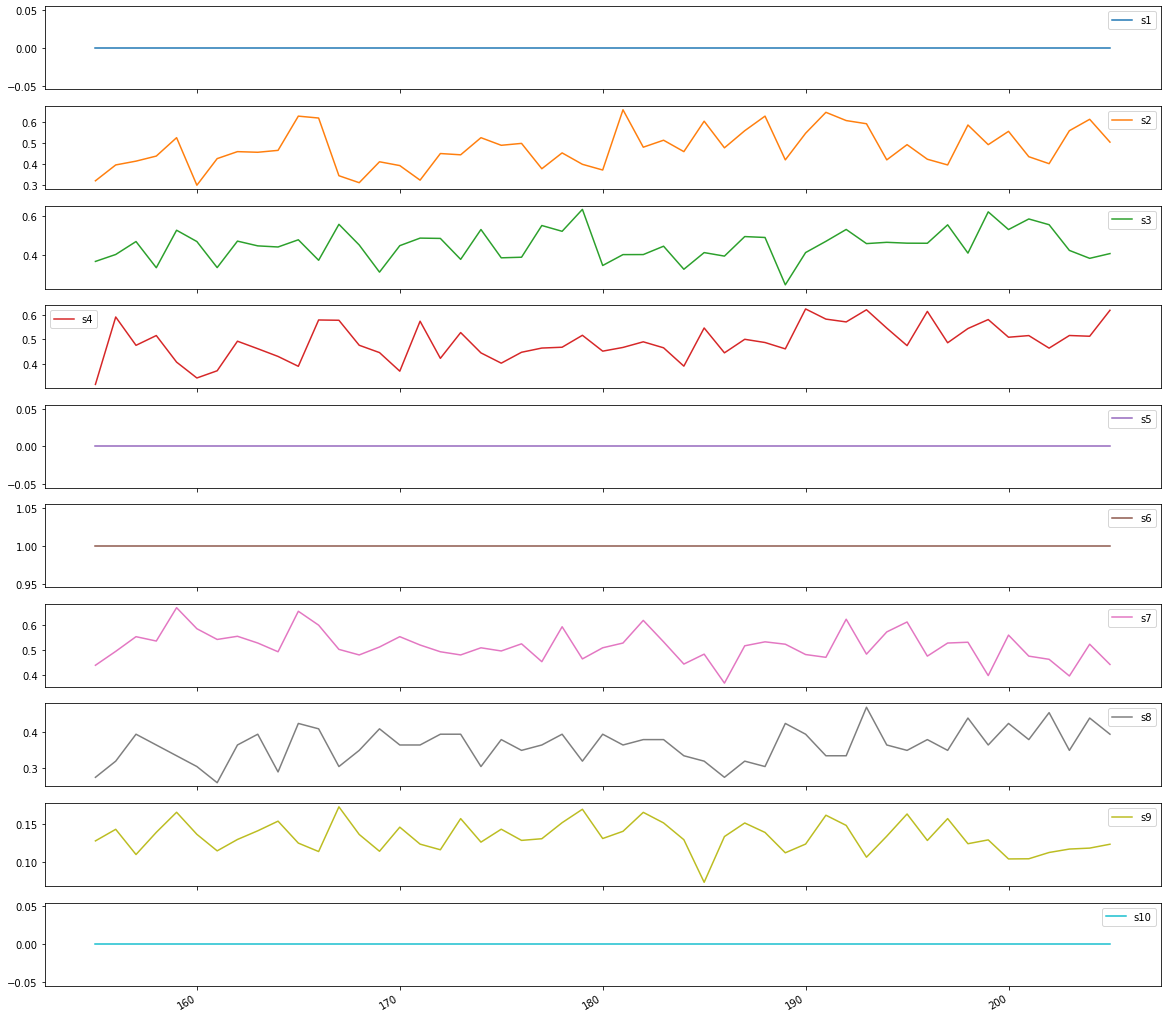

In [145]:
# plotting sensor data for engine ID 3 prior to a failure point - sensors 1-10 
ax1 = engine_id3_50cycleWindow1.plot(subplots=True, sharex=True, figsize=(20,20))

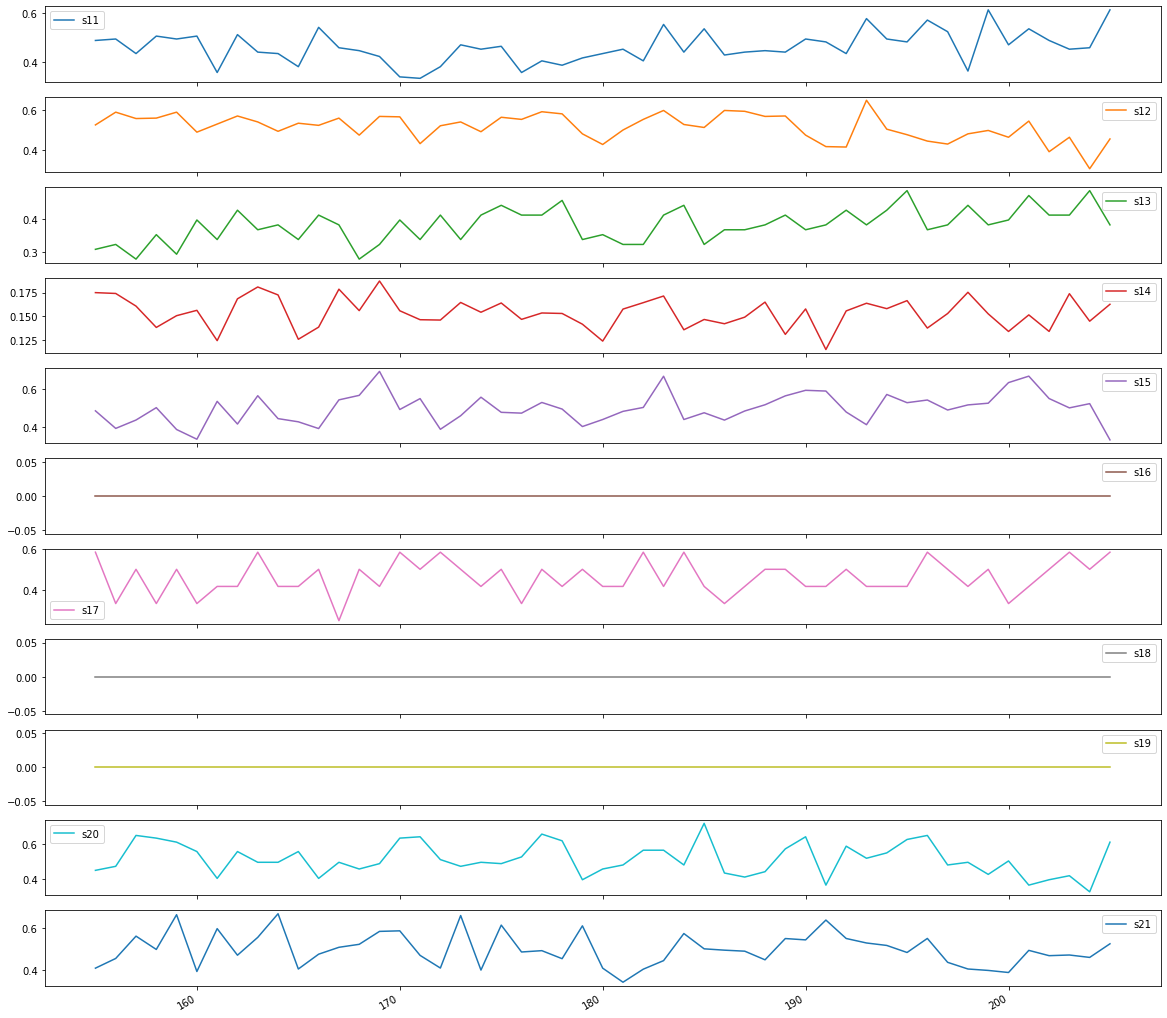

In [146]:
# plotting sensor data for engine ID 3 prior to a failure point - sensors 11-21 
ax2 = engine_id3_50cycleWindow2.plot(subplots=True, sharex=True, figsize=(20,20))

We can see that there are a few sensor values that do not change during throughout the above plots. We can remove these sensor values as part of the data preprocessing. But we can also let the feature engineering be done by the neural network itself. So we keep these sensor values for this notebook.

In [189]:
# function to reshape features into (samples, time steps, features) 
def sequence_from_df(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    # print(f'Num Elements: {num_elements}') # helped in find error
    # for row index start, row index end in
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        # return the data array containing the current 50 rows from the original sequence.
        yield data_array[start:stop, :]

In [152]:
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

In [149]:
sequence_cols

['setting1',
 'setting2',
 'setting3',
 'cycle_norm',
 's1',
 's2',
 's3',
 's4',
 's5',
 's6',
 's7',
 's8',
 's9',
 's10',
 's11',
 's12',
 's13',
 's14',
 's15',
 's16',
 's17',
 's18',
 's19',
 's20',
 's21']

In [190]:
def df_to_seq_array(df, seq_function, seq_len):
    # select the features for the model
    sensor_cols = ['s' + str(i) for i in range(1,22)]
    sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
    sequence_cols.extend(sensor_cols)
    
    # get seq data from df
    seq_gen = (list(seq_function(df[df['id']==id_], seq_len, sequence_cols))
           for id_ in df['id'].unique())
    
    # prepare array for model
    seq_gen = [seq for seq  in seq_gen if len(seq) != 0] # timeseries of lenght less that 50 in test set causes empty array
    seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
    
    return seq_array
    
    
    

In [169]:
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,target_label
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138,0


In [191]:
train_X = df_to_seq_array(train_df, seq_function=sequence_from_df, seq_len=sequence_length)
test_X = df_to_seq_array(test_df, seq_function=sequence_from_df, seq_len=sequence_length)

In [194]:
print(train_X.shape, test_X.shape)

(15631, 50, 25) (8162, 50, 25)


In [64]:
sequence_cols

['setting1',
 'setting2',
 'setting3',
 'cycle_norm',
 's1',
 's2',
 's3',
 's4',
 's5',
 's6',
 's7',
 's8',
 's9',
 's10',
 's11',
 's12',
 's13',
 's14',
 's15',
 's16',
 's17',
 's18',
 's19',
 's20',
 's21']

In [181]:
# generator for the sequences
seq_gen = (list(sequence_from_df(test_df[test_df['id']==id_], sequence_length, sequence_cols)) 
           for id_ in test_df['id'].unique())

In [58]:
seq_list = list(seq_gen)

In [69]:
seq_list[0][0][10]

array([0.60344828, 0.25      , 0.        , 0.02770083, 0.        ,
       0.32228916, 0.23348594, 0.31043214, 0.        , 1.        ,
       0.75523349, 0.22727273, 0.12510096, 0.        , 0.17857143,
       0.57782516, 0.19117647, 0.20972237, 0.41977684, 0.        ,
       0.33333333, 0.        , 0.        , 0.62015504, 0.80709749])

In [182]:
# generate sequences and convert to numpy array
array_list = list(seq_gen)
seq_array = np.concatenate(array_list).astype(np.float32)
seq_array.shape



Num Elements: 31
Num Elements: 49
Num Elements: 126
Num Elements: 106
Num Elements: 98
Num Elements: 105
Num Elements: 160
Num Elements: 166
Num Elements: 55
Num Elements: 192
Num Elements: 83
Num Elements: 217
Num Elements: 195
Num Elements: 46
Num Elements: 76
Num Elements: 113
Num Elements: 165
Num Elements: 133
Num Elements: 135
Num Elements: 184
Num Elements: 148
Num Elements: 39
Num Elements: 130
Num Elements: 186
Num Elements: 48
Num Elements: 76
Num Elements: 140
Num Elements: 158
Num Elements: 171
Num Elements: 143
Num Elements: 196
Num Elements: 145
Num Elements: 50
Num Elements: 203
Num Elements: 198
Num Elements: 126
Num Elements: 121
Num Elements: 125
Num Elements: 37
Num Elements: 133
Num Elements: 123
Num Elements: 156
Num Elements: 172
Num Elements: 54
Num Elements: 152
Num Elements: 146
Num Elements: 73
Num Elements: 78
Num Elements: 303
Num Elements: 74
Num Elements: 144
Num Elements: 189
Num Elements: 164
Num Elements: 121
Num Elements: 113
Num Elements: 136
Num Elem

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 2 has 3 dimension(s)

In [186]:
array_list[12]

[array([[0.36781609, 0.83333333, 0.        , ..., 0.        , 0.60465116,
         0.64512566],
        [0.45402299, 0.5       , 0.        , ..., 0.        , 0.7751938 ,
         0.75932063],
        [0.52298851, 0.5       , 0.        , ..., 0.        , 0.6124031 ,
         0.67771334],
        ...,
        [0.70689655, 0.41666667, 0.        , ..., 0.        , 0.69767442,
         0.65023474],
        [0.5862069 , 0.25      , 0.        , ..., 0.        , 0.58914729,
         0.78044739],
        [0.43678161, 0.66666667, 0.        , ..., 0.        , 0.63565891,
         0.6730185 ]]),
 array([[0.45402299, 0.5       , 0.        , ..., 0.        , 0.7751938 ,
         0.75932063],
        [0.52298851, 0.5       , 0.        , ..., 0.        , 0.6124031 ,
         0.67771334],
        [0.64367816, 0.08333333, 0.        , ..., 0.        , 0.79844961,
         0.77685722],
        ...,
        [0.5862069 , 0.25      , 0.        , ..., 0.        , 0.58914729,
         0.78044739],
        [0.4

In [91]:
# function to generate labels
def gen_labels_for_id(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

In [102]:
# Function to generate the target variable or the train and test data
def get_target_labels(df, get_label_func, seq_len, target_label):
    label = [target_label]
    id_labels = [get_label_func(df[df['id']==id_], sequence_length, label) 
             for id_ in df['id'].unique()]
    label_array = np.concatenate(id_labels).astype(np.float32)
    return label_array
    
    
    

In [50]:
# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id_], sequence_length, ['target_label']) 
             for id_ in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(15631, 1)

In [195]:
train_y = get_target_labels(train_df, gen_labels_for_id, sequence_length, 'target_label')
test_y = get_target_labels(test_df, gen_labels_for_id, sequence_length, 'target_label')
print(train_df_y.shape, test_df_y.shape)

(15631, 1) (8162, 1)


## LSTM Model for Classification

As mentioned earlier, we will use a sequence of length 50.


In [252]:
# build the network
nb_features = train_array_X.shape[2]
nb_out = train_y.shape[1]

model = Sequential()
model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=50,
         return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(
          units=20,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())




Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 50, 50)            15200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 20)                5680      
_________________________________________________________________
dropout_8 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 21        
Total params: 20,901
Trainable params: 20,901
Non-trainable params: 0
_________________________________________________________________
None


In [254]:
%%time
# fit the network
# callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')]
history = model.fit(train_X, train_y, epochs=20, batch_size=1024, validation_data=[test_X, test_y], verbose=1,
          )

Train on 15631 samples, validate on 8162 samples
Epoch 1/20
15631/15631 [==============================] - 15s 950us/step - loss: 0.4290 - accuracy: 0.8030 - val_loss: 0.1487 - val_accuracy: 0.9593
Epoch 2/20
15631/15631 [==============================] - 16s 1ms/step - loss: 0.2743 - accuracy: 0.8848 - val_loss: 0.1013 - val_accuracy: 0.9650
Epoch 3/20
15631/15631 [==============================] - 17s 1ms/step - loss: 0.2194 - accuracy: 0.9198 - val_loss: 0.0834 - val_accuracy: 0.9716
Epoch 4/20
15631/15631 [==============================] - 17s 1ms/step - loss: 0.1677 - accuracy: 0.9415 - val_loss: 0.0672 - val_accuracy: 0.9771
Epoch 5/20
15631/15631 [==============================] - 17s 1ms/step - loss: 0.1278 - accuracy: 0.9537 - val_loss: 0.0699 - val_accuracy: 0.9781
Epoch 6/20
15631/15631 [==============================] - 18s 1ms/step - loss: 0.1042 - accuracy: 0.9641 - val_loss: 0.0472 - val_accuracy: 0.9799
Epoch 7/20
15631/15631 [==============================] - 17s 1ms/s

### Vizualising the Accuracy and the Loss of the trained model.

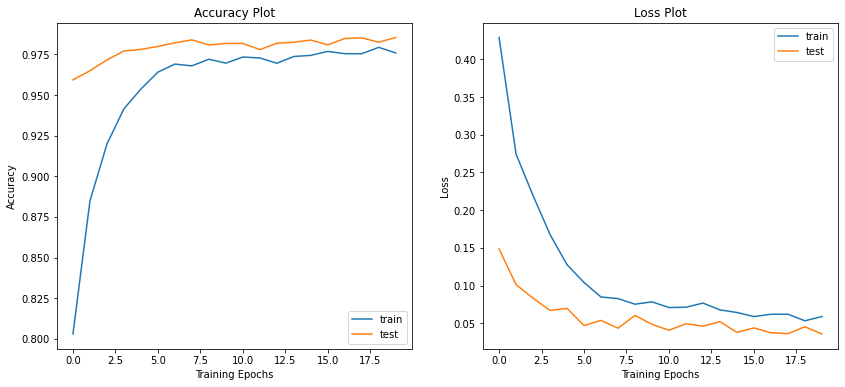

In [255]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(14,6))
ax[0].plot(history.history['accuracy'], label = 'train')
ax[0].plot(history.history['val_accuracy'], label = 'test')
ax[0].legend()
ax[0].set_title('Accuracy Plot')
ax[0].set_xlabel('Training Epochs')
ax[0].set_ylabel('Accuracy')
ax[1].plot(history.history['loss'], label='train')
ax[1].plot(history.history['val_loss'], label= 'test')
ax[1].legend()
ax[1].set_title('Loss Plot')
ax[1].set_xlabel('Training Epochs')
ax[1].set_ylabel('Loss')

plt.show()

### Making Predictions on Test Data

In [256]:

y_pred = model.predict_classes(test_X, batch_size=2048, verbose=1)

8162/8162 [==============================] - 2s 206us/step


In [257]:
y_actual = test_y
cm = confusion_matrix(y_actual, y_pred)
print(cm)

[[7806   24]
 [  95  237]]


In [258]:
# compute precision and recall
precision_test = precision_score(y_actual, y_pred)
recall_test = recall_score(y_actual, y_pred)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

Precision:  0.9080459770114943 
 Recall:  0.713855421686747 
 F1-score: 0.7993254637436761
